# PART 1: Simple Markowitz-Model implementation to estimate weightage of each stock in portfolio, where portfolio will have highest sharpe ratio


In [680]:
### PART 1: Simple Markowitz-Model implementation to estimate weightage of each stock in portfolio, where portfolio will have highest sharpe ratio

# Step 1: Import modules and define constants
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as optimization

# On avge, 252 trading days a year
NUM_TRADING_DAYS = 252

# Generate random w (diff. portfolios)
NUM_PORTFOLIOS = 10000

# Our portfolio stocks
stocks = ['AAPL', 'NVDA', 'MAR', 'LMT', 'BA']

# Historical data - define START, END dates
start_date = '2010-01-01'
end_date = '2023-10-01'

In [681]:
# Step 2: Data retrieval and Visualisation
def download_data():
    # name of stock as key, stock values 2010-2023
    stock_data = {}
    for stock in stocks:
        ticker = yf.Ticker(stock)
        stock_data[stock] = ticker.history(start=start_date, end=end_date)['Close']
    return pd.DataFrame(stock_data)

def show_data(data):
    data.plot(figsize=(10, 5))
    plt.show()

In [682]:
# Step 3: Returns calculation and Portfolio Statistics
# To calculate return using normalisation, show statistics using annual metrics
def calculate_return(data):
    # Normalization - to measure variables in comparable metric
    log_return = np.log(data / data.shift(1))
    return log_return[1:]                    # Don't need first row of dataset, since values are NaN

def show_statistics(returns):
    # Instead of daily metrics, use annual metrics
    annual_mean = returns.mean() * NUM_TRADING_DAYS
    annual_covariance = returns.cov() * NUM_TRADING_DAYS
    print("Annual Mean Returns:")
    print(annual_mean)
    print("Annual Covariance Matrix:")
    print(annual_covariance)

In [683]:
# Step 4: To visaulise efficient frontier and displau portfolio metrics
def show_mean_variance(returns, weights):
    portfolio_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * NUM_TRADING_DAYS, weights)))
    print("Expected portfolio mean (return): ", portfolio_return)
    print("Expected portfolio volatility (standard deviation): ", portfolio_volatility)


# Generate multiple portfolios: Display their efficient frontier
def show_portfolios(returns, volatilities):
    plt.figure(figsize=(10, 6))
    plt.scatter(volatilities, returns, c=returns/volatilities, marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.show()

In [684]:
# Step 5: Portfolio Generation
def generate_portfolios(returns):
    portfolio_means = []
    portfolio_risks = []
    portfolio_weights = []

    for _ in range(NUM_PORTFOLIOS):
        # Generate random weight
        w = np.random.random(len(stocks))
        w /= np.sum(w)
        portfolio_weights.append(w)
        portfolio_mean = np.sum(returns.mean() * w) * NUM_TRADING_DAYS
        portfolio_risk = np.sqrt(np.dot(w.T, np.dot(returns.cov() * NUM_TRADING_DAYS, w)))
        portfolio_means.append(portfolio_mean)
        portfolio_risks.append(portfolio_risk)

    return np.array(portfolio_weights), np.array(portfolio_means), np.array(portfolio_risks)


In [685]:
# Step 6: Portfolio Optimization Functions
def statistics(weights, returns):
    portfolio_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * NUM_TRADING_DAYS, weights)))
    return np.array([portfolio_return, portfolio_volatility, portfolio_return / portfolio_volatility])

# Scipy optimize module can find the minimum of a given function
# Maximum of f(x) is minimum of -f(x)
def min_function_sharpe(weights, returns):
    return -statistics(weights, returns)[2]

# Constraints: Sum of weights = 1
# f(x) = 0 this is the function to minimize
def optimize_portfolio(weights, returns):
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    # Weights can be 1 at most: 1 when 100% of money invested in single stock
    bounds = tuple((0, 1) for _ in range(len(stocks)))
    return optimization.minimize(fun=min_function_sharpe, x0=weights[0], args=returns, method='SLSQP', bounds=bounds, constraints=constraints)


In [686]:
# Step 7: Portfolio Results Presentation
def print_optimal_portfolio(optimum, returns):
    print("Optimal portfolio weights:", optimum['x'].round(3))
    expected_return, volatility, sharpe_ratio = statistics(optimum['x'].round(3), returns)
    print(f"Expected return: {expected_return}")
    print(f"Expected volatility (standard deviation): {volatility}")
    print(f"Sharpe ratio: {sharpe_ratio}")

def show_optimal_portfolio(opt, rets, portfolio_rets, portfolio_vols):
    plt.figure(figsize=(10, 6))
    plt.scatter(portfolio_vols, portfolio_rets, c=portfolio_rets / portfolio_vols, marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.plot(statistics(opt['x'], rets)[1], statistics(opt['x'], rets)[0], 'g*', markersize=20.0)
    plt.show()

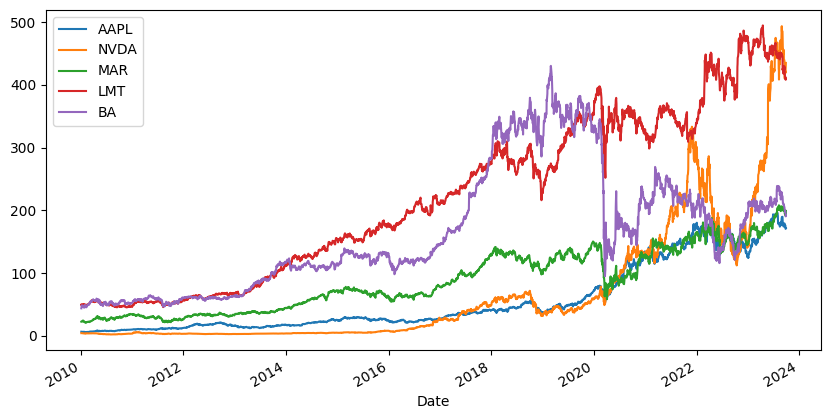



Annual Mean Returns:
AAPL    0.238519
NVDA    0.337450
MAR     0.157839
LMT     0.153483
BA      0.107614
dtype: float64
Annual Covariance Matrix:
          AAPL      NVDA       MAR       LMT        BA
AAPL  0.080627  0.064419  0.036103  0.021053  0.041491
NVDA  0.064419  0.200282  0.054602  0.025807  0.060011
MAR   0.036103  0.054602  0.098672  0.022343  0.065004
LMT   0.021053  0.025807  0.022343  0.044809  0.036176
BA    0.041491  0.060011  0.065004  0.036176  0.130475




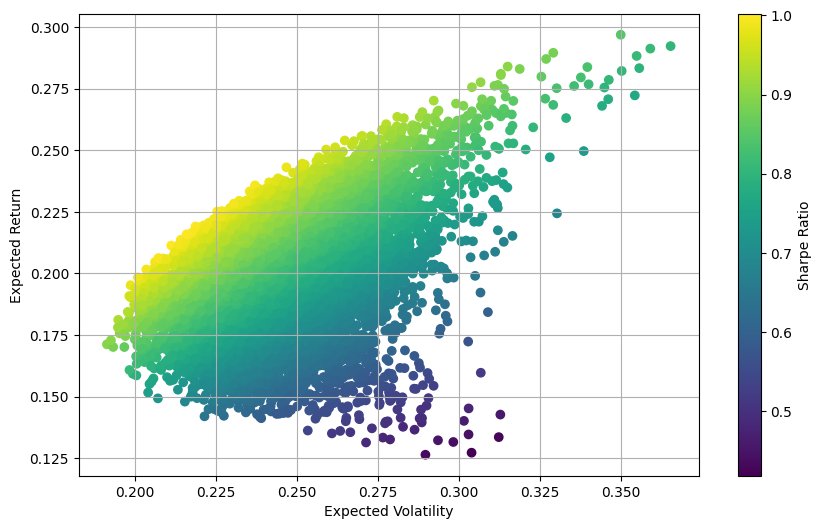



Optimal portfolio weights: [0.364 0.182 0.004 0.45  0.   ]
Expected return: 0.21793547582749112
Expected volatility (standard deviation): 0.21521349139117776
Sharpe ratio: 1.0126478336405305


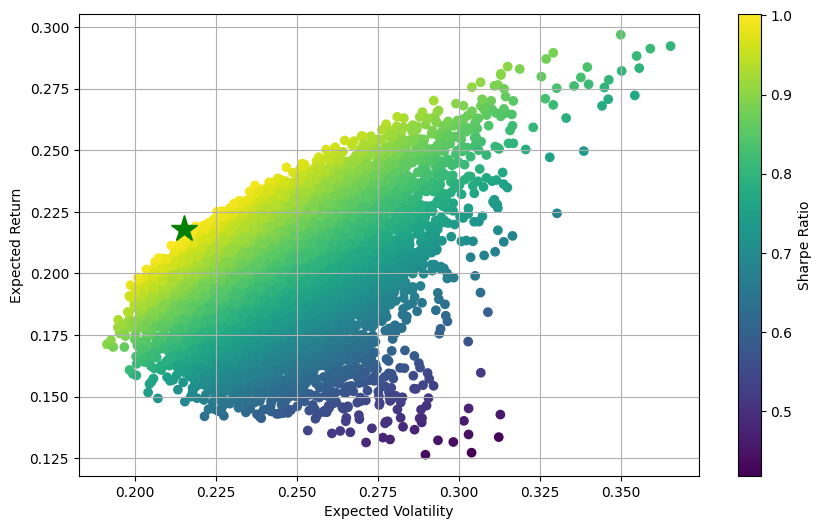

In [687]:
# Main Workflow
# First output: Display stock prices of the 5 stocks, using yfinance
dataset = download_data()
show_data(dataset)
print('\n')

# Second output: Annual Mean returns and covariance matrix of stocks in portfolio
log_daily_returns = calculate_return(dataset)
show_statistics(log_daily_returns)
print('\n')

# Third output: Display Scatterplot of expected return against expected volatility, color coded by sharpe ratio
weights, means, risks = generate_portfolios(log_daily_returns)
show_portfolios(means, risks)
print('\n')

# Fourth output: Display most optimal portfolio (highest sharpe ratio), denoted by green star
# Each value in the list for optimal portfolio shows the corresponding optimal percentage each stock should take in portfolio
optimum = optimize_portfolio(weights, log_daily_returns)
print_optimal_portfolio(optimum, log_daily_returns)
show_optimal_portfolio(optimum, log_daily_returns, means, risks)

# Part 2: Incorporating sentiment score of earnings call and technical indicators with stock data

In [688]:
### PART 2: Analysing of the 5 stock prices, with incorporation of their corresponding sentiment score (extracted using NLP and FinBert)
### NOTE: Wil not be forecasting prices because there are measured in absolute terms and thus harder to compare across time and other assets.
###       Hence, will be forecasting daily returns instead

# Step 1: Import modules and load data
import yfinance as yf
import math
from datetime import date
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns

In [689]:
stocks = ['AAPL', 'NVDA', 'MAR', 'LMT', 'BA']
# stocks = []
stock_data = yf.download(stocks, start='2010-01-01', end='2023-10-20', group_by='tickers')
stock_data.head()

[*********************100%%**********************]  5 of 5 completed


MAR                                                       \
                 Open       High        Low      Close  Adj Close   Volume   
Date                                                                         
2010-01-04  26.022619  26.324223  25.636192  26.041470  22.534811  2860350   
2010-01-05  25.984921  26.314796  25.796417  26.192270  22.665291  2627885   
2010-01-06  26.145145  26.409048  25.947220  26.267672  22.730545  2789900   
2010-01-07  26.154572  26.550425  26.107447  26.371347  22.820265  2560724   
2010-01-08  26.182846  26.550425  26.163996  26.427898  22.869209  3961031   

              NVDA                         ...         BA             \
              Open   High     Low   Close  ...        Low      Close   
Date                                       ...                         
2010-01-04  4.6275  4.655  4.5275  4.6225  ...  54.799999  56.180000   
2010-01-05  4.6050  4.740  4.6050  4.6900  ...  56.000000  58.020000   
2010-01-06  4.6875  4.730  4.6425  4.7200  ...  57.880001  59.779999   
2010-01-07  4.6950  4.715  4.5925  4.6275  ...  59.020000  62.200001   
2010-01-08  4.5900  4.670  4.5625  4.6375  ...  60.860001  61.599998   

                                       LMT                                   \
            Adj Close    Volume       Open       High        Low      Close   
Date                                                                          
2010-01-04  43.777550   6186700  75.870003  76.949997  75.519997  76.849998   
2010-01-05  45.211346   8867800  76.620003  77.790001  76.550003  77.650002   
2010-01-06  46.582798   8836500  76.099998  77.190002  75.849998  76.510002   
2010-01-07  48.468548  14379100  76.169998  76.199997  73.610001  74.410004   
2010-01-08  48.001022   7146600  74.349998  75.940002  74.320000  75.610001   

                                
            Adj Close   Volume  
Date                            
2010-01-04  49.773975  2408300  
2010-01-05  50.292114  2356500  
2010-01-06  49.553768  5208100  
2010-01-07  48.193672  7038300  
2010-01-08  48.970852  3629400  

[5 rows x 30 columns]

In [690]:
# Step 2: Clean and explore data
stock_data.describe()

MAR                                                      \
              Open         High          Low        Close    Adj Close   
count  3473.000000  3473.000000  3473.000000  3473.000000  3473.000000   
mean     91.785428    92.861702    90.708125    91.821133    88.078615   
std      48.546887    49.150517    47.958425    48.564686    49.435964   
min      24.175306    24.693686    24.024506    24.260132    20.993336   
25%      41.419998    41.689999    40.970001    41.389999    37.193230   
50%      81.209999    81.989998    80.059998    81.000000    75.676712   
75%     134.919998   136.449997   133.490005   135.050003   131.097137   
max     208.389999   210.979996   207.600006   208.509995   207.983658   

                            NVDA                                         ...  \
             Volume         Open         High          Low        Close  ...   
count  3.473000e+03  3473.000000  3473.000000  3473.000000  3473.000000  ...   
mean   2.855895e+06    67.350733    68.593902    66.066085    67.381228  ...   
std    1.881032e+06    98.896408   100.733723    96.943027    98.886316  ...   
min    4.452000e+05     2.180000     2.262500     2.162500     2.220000  ...   
25%    1.715800e+06     4.182500     4.250000     4.107500     4.185000  ...   
50%    2.337100e+06    23.025000    23.152500    22.512501    22.955000  ...   
75%    3.418700e+06    78.074997    79.080002    75.947502    78.025002  ...   
max    2.588180e+07   502.160004   502.660004   489.579987   493.549988  ...   

                BA                                                  LMT  \
               Low        Close    Adj Close        Volume         Open   
count  3473.000000  3473.000000  3473.000000  3.473000e+03  3473.000000   
mean    171.682289   173.751471   164.182916  7.310036e+06   250.547558   
std      93.042401    94.168854    96.619565  8.694362e+06   129.657013   
min      54.799999    56.180000    43.777550  7.889000e+05    66.989998   
25%      99.300003   100.750000    86.017082  3.443600e+06   106.910004   
50%     143.979996   145.860001   132.949997  4.725000e+06   255.100006   
75%     215.910004   218.110001   218.110001  7.371100e+06   362.299988   
max     440.190002   440.619995   430.299988  1.032128e+08   502.000000   

                                                                         
              High          Low        Close    Adj Close        Volume  
count  3473.000000  3473.000000  3473.000000  3473.000000  3.473000e+03  
mean    252.693110   248.401342   250.563409   220.310309  1.662178e+06  
std     130.908460   128.383067   129.615066   132.109984  1.072282e+06  
min      68.400002    66.360001    66.870003    45.362427  3.209000e+05  
25%     107.709999   106.260002   107.050003    80.153687  1.038300e+06  
50%     257.000000   252.770004   254.970001   212.356522  1.365100e+06  
75%     365.579987   359.450012   361.989990   334.732727  1.935600e+06  
max     508.100006   498.000000   501.410004   494.749481  1.396230e+07  

[8 rows x 30 columns]

In [691]:
# Check for presence of missing values
missing_values_count = stock_data.isnull().sum()
missing_values_count

MAR   Open         0
      High         0
      Low          0
      Close        0
      Adj Close    0
      Volume       0
NVDA  Open         0
      High         0
      Low          0
      Close        0
      Adj Close    0
      Volume       0
AAPL  Open         0
      High         0
      Low          0
      Close        0
      Adj Close    0
      Volume       0
BA    Open         0
      High         0
      Low          0
      Close        0
      Adj Close    0
      Volume       0
LMT   Open         0
      High         0
      Low          0
      Close        0
      Adj Close    0
      Volume       0
dtype: int64

In [692]:
# Check shape of dataframe
stock_data.shape

(3473, 30)

In [693]:
# Check columns of dataframe
stock_data.columns

MultiIndex([( 'MAR',      'Open'),
            ( 'MAR',      'High'),
            ( 'MAR',       'Low'),
            ( 'MAR',     'Close'),
            ( 'MAR', 'Adj Close'),
            ( 'MAR',    'Volume'),
            ('NVDA',      'Open'),
            ('NVDA',      'High'),
            ('NVDA',       'Low'),
            ('NVDA',     'Close'),
            ('NVDA', 'Adj Close'),
            ('NVDA',    'Volume'),
            ('AAPL',      'Open'),
            ('AAPL',      'High'),
            ('AAPL',       'Low'),
            ('AAPL',     'Close'),
            ('AAPL', 'Adj Close'),
            ('AAPL',    'Volume'),
            (  'BA',      'Open'),
            (  'BA',      'High'),
            (  'BA',       'Low'),
            (  'BA',     'Close'),
            (  'BA', 'Adj Close'),
            (  'BA',    'Volume'),
            ( 'LMT',      'Open'),
            ( 'LMT',      'High'),
            ( 'LMT',       'Low'),
            ( 'LMT',     'Close'),
            ( 'LMT',

In [694]:
aapl = yf.Ticker('AAPL')

# uncomment later
# aapl.info

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Line charts for AAPL: 



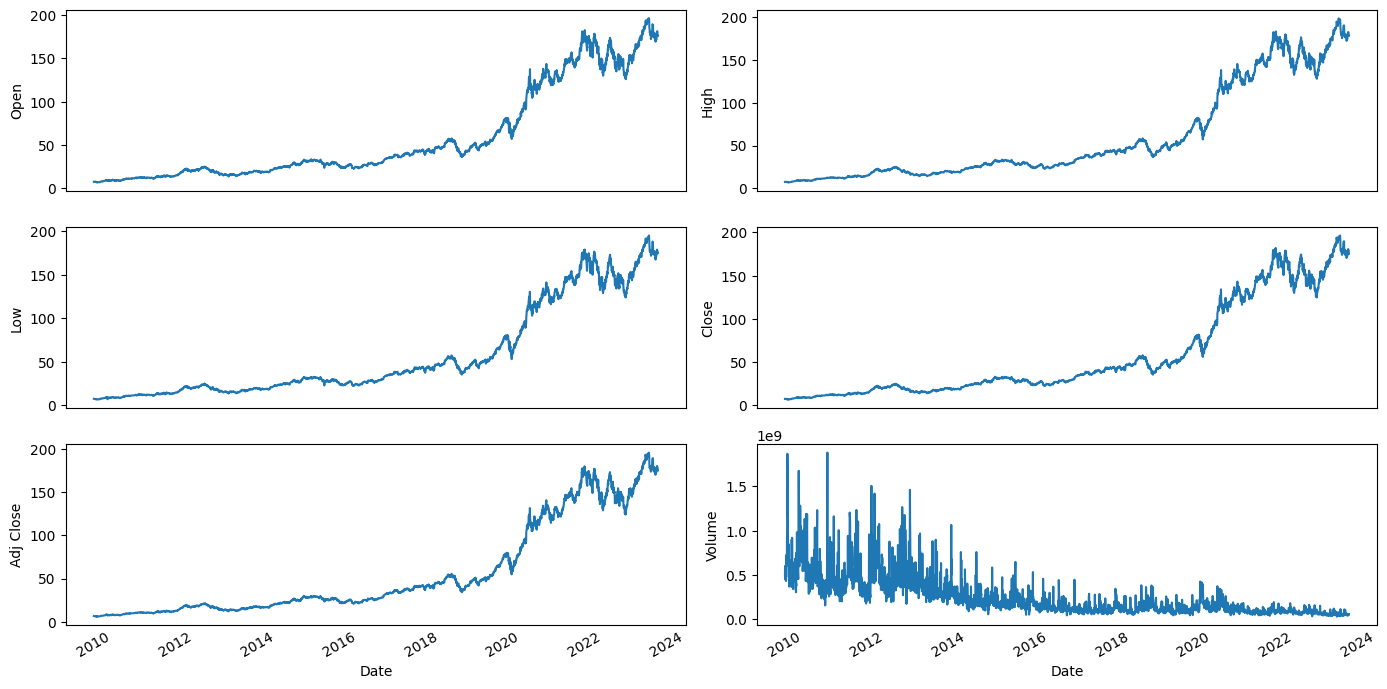

Line charts for NVDA: 



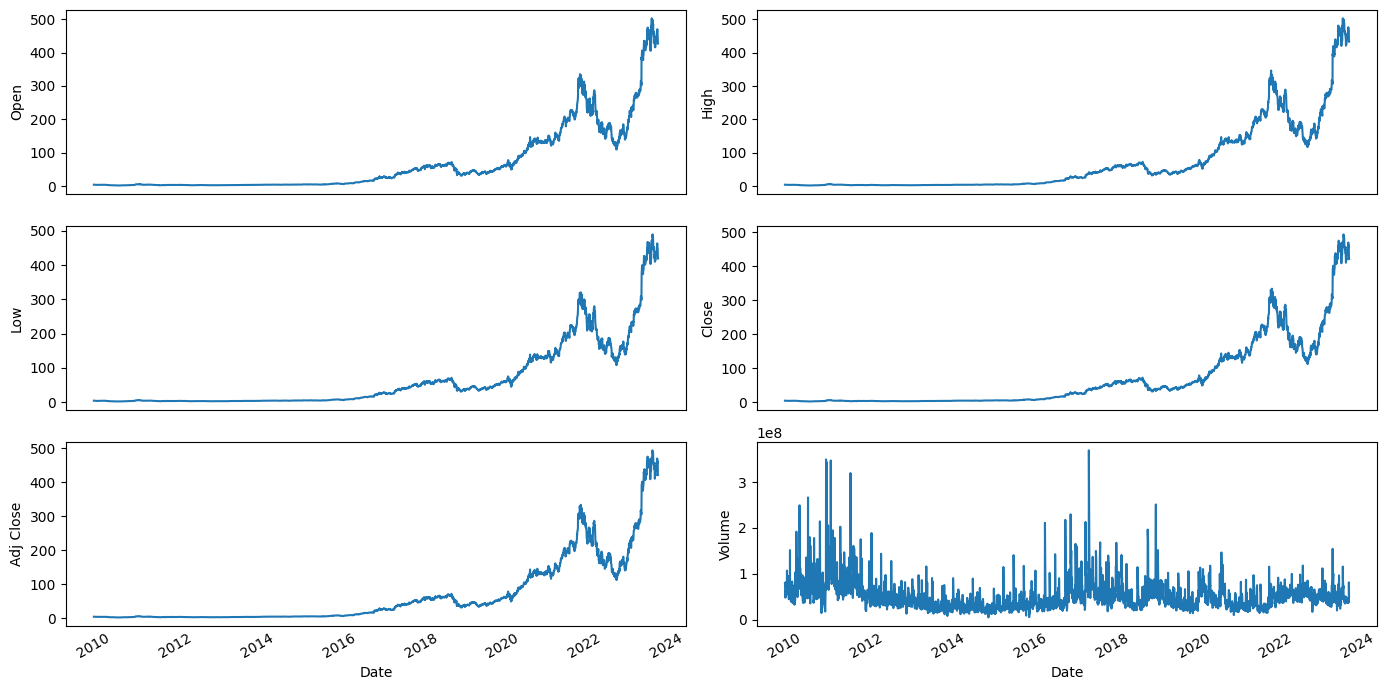

Line charts for MAR: 



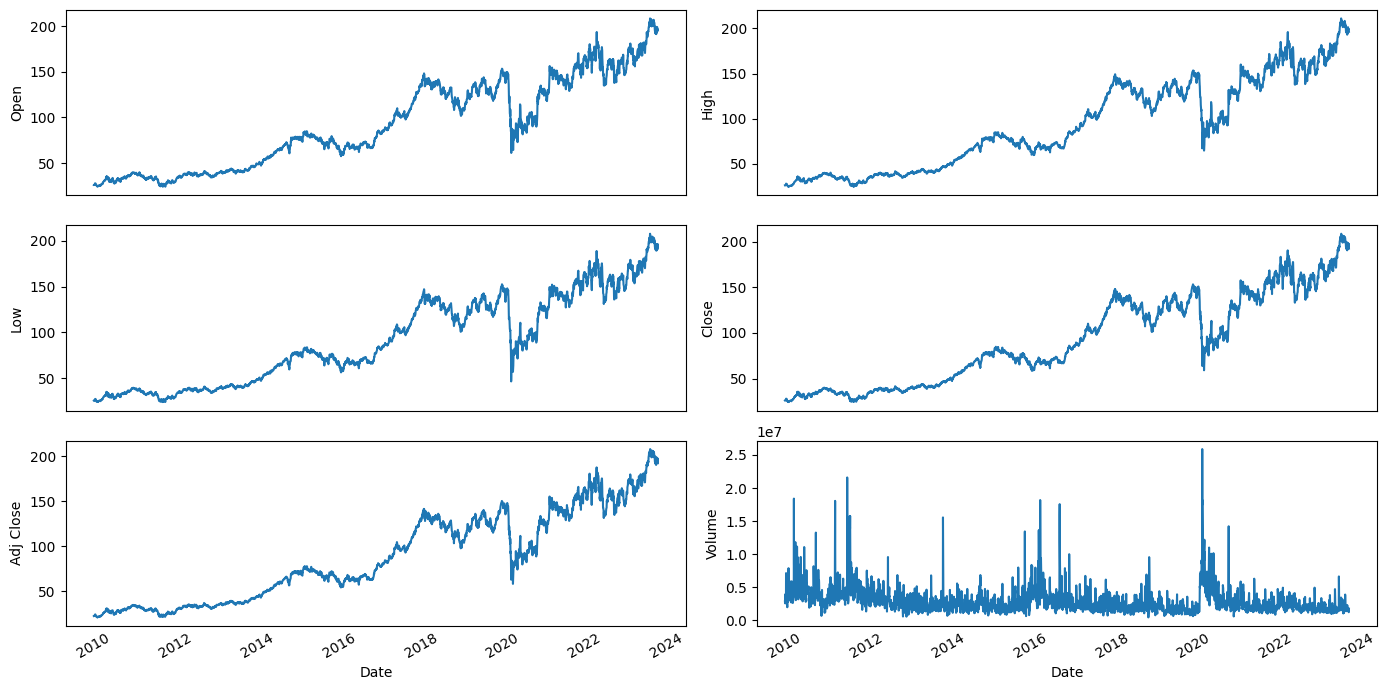

Line charts for LMT: 



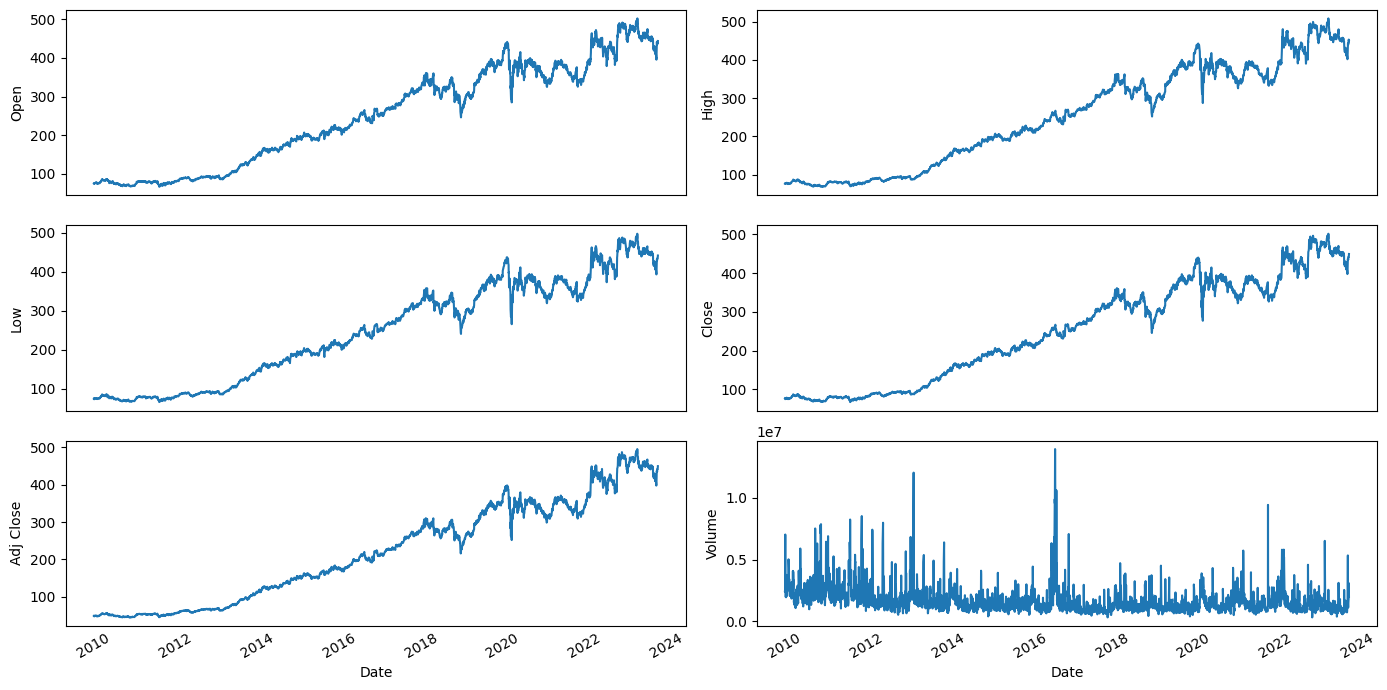

Line charts for BA: 



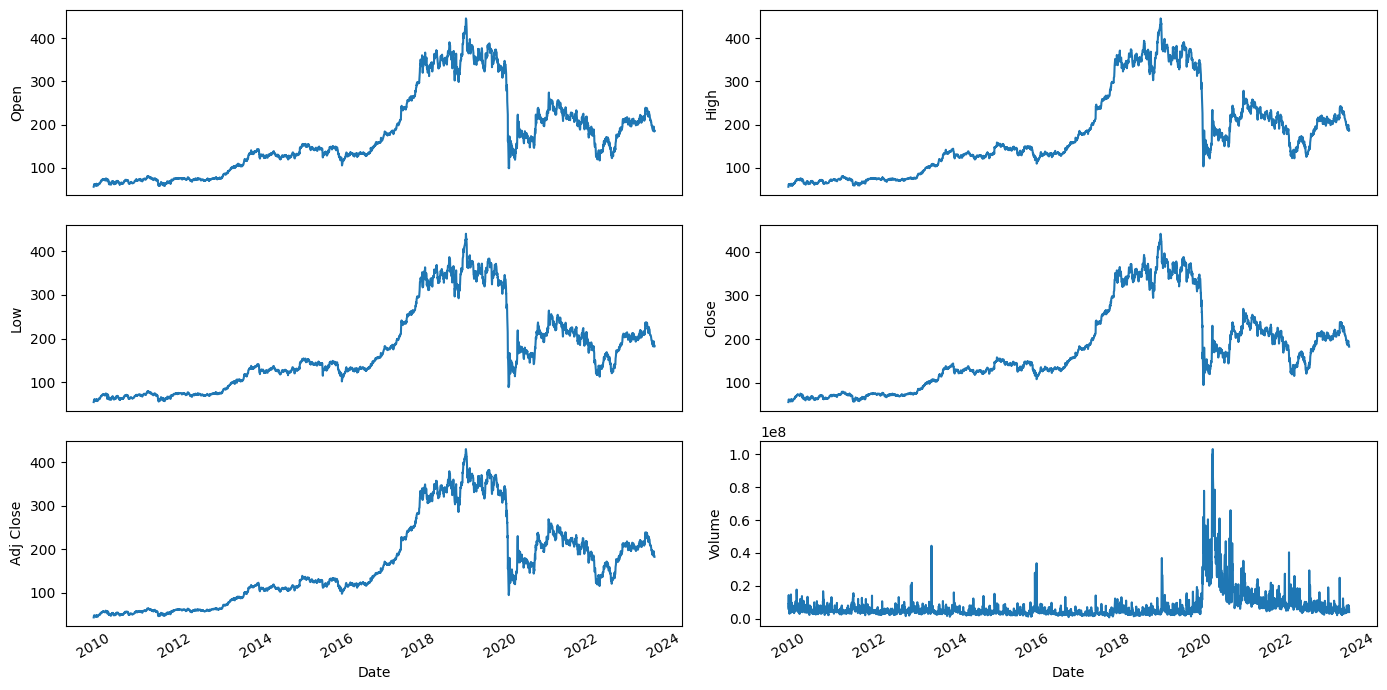

In [695]:
# Explore data: Create line charts for columns of dataset
# Define the DataFrame to plot (Will display line charts for 5 stocks separately here for ease of visualisation)
aapl_df = yf.download('AAPL', start='2010-01-01', end='2023-10-20')
nvda_df = yf.download('NVDA', start='2010-01-01', end='2023-10-20')
mar_df = yf.download('MAR', start='2010-01-01', end='2023-10-20')
lmt_df = yf.download('LMT', start='2010-01-01', end='2023-10-20')
ba_df = yf.download('BA', start='2010-01-01', end='2023-10-20')

# Function to plot line chart of every stock in stock_df (For a quick glance)
def plot_line_charts(stock_df):
    # Plot line charts
    df_plot = stock_df.copy()

    ncols = 2
    nrows = int(round(df_plot.shape[1] / ncols, 0))

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
    for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    fig.tight_layout()
    plt.show()

print("Line charts for AAPL: \n")
plot_line_charts(aapl_df)
print("Line charts for NVDA: \n")
plot_line_charts(nvda_df)
print("Line charts for MAR: \n")
plot_line_charts(mar_df)
print("Line charts for LMT: \n")
plot_line_charts(lmt_df)
print("Line charts for BA: \n")
plot_line_charts(ba_df)

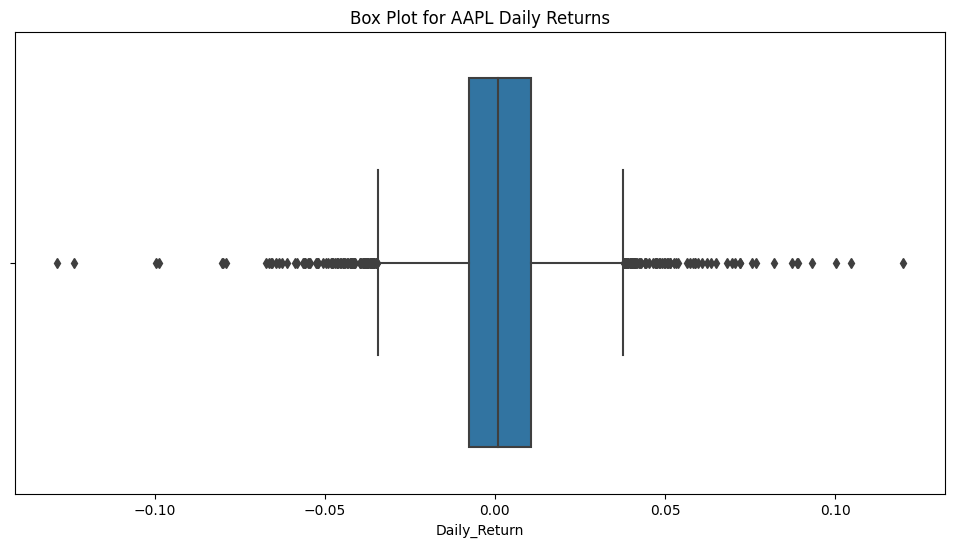

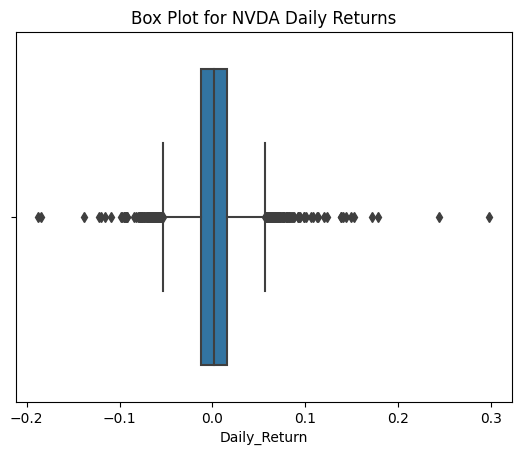

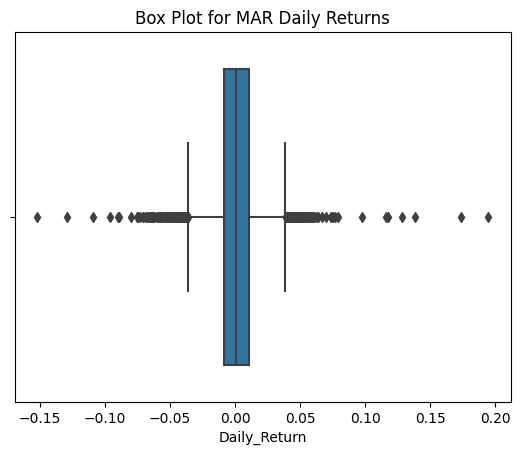

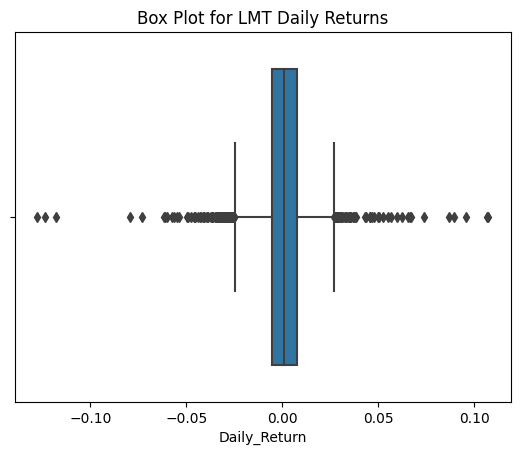

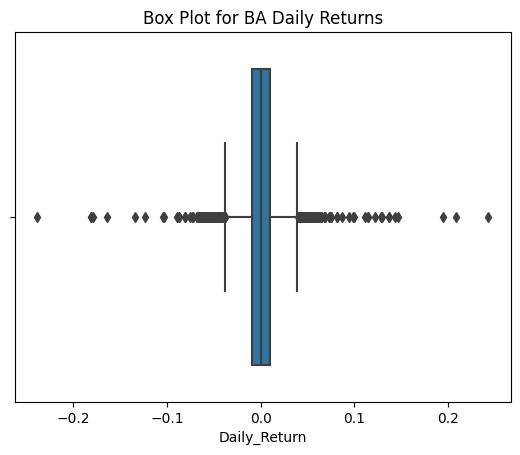

In [696]:
# Step 3: Feature Engineering
# Forecast daily returns by creating return column and analyse possible outliers using boxplot

for stock in stocks:
    stock_data[stock, 'Daily_Return'] = stock_data[stock]['Adj Close'].pct_change()
    stock_data = stock_data.sort_index(axis=1)
# print(stock_data)

# Perform data analysis to identify possible outliers
plt.figure(figsize=(12, 6))
for stock in stocks:
    sns.boxplot(x=stock_data[stock]["Daily_Return"])
    plt.title(f'Box Plot for {stock} Daily Returns')
    plt.show()
    print("\n")

In [697]:
# Using log transformation to reduce the impact of outliers, instead of removing them


# Since we feel that outliers are meaningful and representative of actual market conditions/events, we decide not to remove them
stock_data.head()

AAPL                                                       \
           Adj Close     Close Daily_Return      High       Low      Open   
Date                                                                        
2010-01-04  6.487535  7.643214          NaN  7.660714  7.585000  7.622500   
2010-01-05  6.498750  7.656429     0.001729  7.699643  7.616071  7.664286   
2010-01-06  6.395379  7.534643    -0.015906  7.686786  7.526786  7.656429   
2010-01-07  6.383556  7.520714    -0.001849  7.571429  7.466071  7.562500   
2010-01-08  6.425995  7.570714     0.006648  7.571429  7.466429  7.510714   

                              BA                          ...        MAR  \
               Volume  Adj Close      Close Daily_Return  ...        Low   
Date                                                      ...              
2010-01-04  493729600  43.777550  56.180000          NaN  ...  25.636192   
2010-01-05  601904800  45.211346  58.020000     0.032752  ...  25.796417   
2010-01-06  552160000  46.582798  59.779999     0.030334  ...  25.947220   
2010-01-07  477131200  48.468548  62.200001     0.040482  ...  26.107447   
2010-01-08  447610800  48.001022  61.599998    -0.009646  ...  26.163996   

                                    NVDA                                      \
                 Open   Volume Adj Close   Close Daily_Return   High     Low   
Date                                                                           
2010-01-04  26.022619  2860350  4.240799  4.6225          NaN  4.655  4.5275   
2010-01-05  25.984921  2627885  4.302728  4.6900     0.014603  4.740  4.6050   
2010-01-06  26.145145  2789900  4.330250  4.7200     0.006396  4.730  4.6425   
2010-01-07  26.154572  2560724  4.245388  4.6275    -0.019597  4.715  4.5925   
2010-01-08  26.182846  3961031  4.254561  4.6375     0.002161  4.670  4.5625   

                              
              Open    Volume  
Date                          
2010-01-04  4.6275  80020400  
2010-01-05  4.6050  72864800  
2010-01-06  4.6875  64916800  
2010-01-07  4.6950  54779200  
2010-01-08  4.5900  47816800  

[5 rows x 35 columns]

#Import Sentiment score from Excel

In [698]:
# Adding text sentiment score as an additional column to dataframe

# Import excel data of sentiment score as dataframe
df_sentiment_score = pd.read_excel("sentiment_score.xlsx")
df_sentiment_score

,filename,sentiment_score
0,2016-Jan-28-BA.N-138020839119-Transcript.txt,0.290381
1,2015-Apr-22-BA.N-140063175207-Transcript.txt,0.187387
2,2022-Oct-26-BA.N-140697322944-Transcript.txt,0.086556
3,2010-Jul-28-BA.N-137028827968-Transcript.txt,0.052885
4,2014-Jan-29-BA.N-139067099110-Transcript.txt,0.257669
...,...,...
269,2017-May-03-AAPL.OQ-137410537849-Transcript.txt,0.266504
270,2015-Oct-28-AAPL.OQ-139180636945-Transcript.txt,0.286697
271,2012-Jul-25-AAPL.OQ-138648438585-Transcript.txt,0.175141
272,2011-Apr-21-AAPL.OQ-140555924186-Transcript.txt,0.204651


In [699]:
# Convert filename column, data will be in the format of YYYY-MM-DD.TickerName
def convert_column(filename):
    file_name_splitted = filename.split('.')
    final_file_name = ""
    month_to_numeric = {"Jan": "01",
                        "Feb": "02",
                        "Mar": "03",
                        "Apr": "04",
                        "May": "05",
                        "Jun": "06",
                        "Jul": "07",
                        "Aug": "08",
                        "Sep": "09",
                        "Oct": "10",
                        "Nov": "11",
                        "Dec": "12"
                        }

    splitted_by_dash = file_name_splitted[0].split('-')
    month_alphabet = splitted_by_dash[1]
    month_numeric = month_to_numeric[month_alphabet]
    final_file_name += splitted_by_dash[0] + "-" + month_numeric + "-" + splitted_by_dash[2] + "." + splitted_by_dash[3]

    return final_file_name

df_sentiment_score['filename'] = df_sentiment_score['filename'].apply(convert_column)
df_sentiment_score

,filename,sentiment_score
0,2016-01-28.BA,0.290381
1,2015-04-22.BA,0.187387
2,2022-10-26.BA,0.086556
3,2010-07-28.BA,0.052885
4,2014-01-29.BA,0.257669
...,...,...
269,2017-05-03.AAPL,0.266504
270,2015-10-28.AAPL,0.286697
271,2012-07-25.AAPL,0.175141
272,2011-04-21.AAPL,0.204651


In [700]:
# Function to make the date as row index, while column will be stock ticker
def format_filename(row):
    parts = row['filename'].split('.')
    return pd.Series([parts[0], parts[1], row['sentiment_score']], index=['Date', 'Ticker', 'Sentiment_score'])

# Apply the function to each row and restructure the DataFrame
df_sentiment_score = df_sentiment_score.apply(format_filename, axis=1)

# Set the 'Date' column as the row index
df_sentiment_score.set_index('Date', inplace=True)
# df_sentiment_score.groupby("Ticker")


In [701]:
df_sentiment_score = df_sentiment_score.groupby("Ticker")

sentiment_score_dict = {}
for stock in stocks:
    suffixed_df = df_sentiment_score.get_group(f"{stock}").add_prefix(f'{stock}_')
    suffixed_df.drop([f"{stock}_Ticker"], axis=1, inplace=True)
    new_df = suffixed_df.reset_index('Date')
    sentiment_score_dict[f'{stock}_df_sentiment_score'] = new_df
    

# print(sentiment_score_dict)
    

In [702]:
sentiment_score_dict

{'AAPL_df_sentiment_score':           Date  AAPL_Sentiment_score
 0   2019-01-30              0.219626
 1   2023-08-04              0.300216
 2   2011-01-19              0.287645
 3   2022-04-29              0.177384
 4   2011-07-20              0.257669
 5   2021-10-29              0.228690
 6   2013-01-24              0.169261
 7   2013-07-24              0.160088
 8   2021-04-29              0.266525
 9   2018-08-01              0.340686
 10  2012-04-25              0.170018
 11  2017-02-01              0.325980
 12  2018-11-02              0.314861
 13  2014-10-21              0.230620
 14  2019-07-31              0.364269
 15  2014-07-23              0.242152
 16  2011-10-19              0.238876
 17  2016-01-27              0.204167
 18  2015-01-28              0.230189
 19  2015-07-22              0.303419
 20  2012-10-26              0.194981
 21  2016-10-26              0.216110
 22  2020-07-31              0.263789
 23  2015-04-28              0.268482
 24  2020-01-29        

In [703]:
stock_data.head()

AAPL                                                       \
           Adj Close     Close Daily_Return      High       Low      Open   
Date                                                                        
2010-01-04  6.487535  7.643214          NaN  7.660714  7.585000  7.622500   
2010-01-05  6.498750  7.656429     0.001729  7.699643  7.616071  7.664286   
2010-01-06  6.395379  7.534643    -0.015906  7.686786  7.526786  7.656429   
2010-01-07  6.383556  7.520714    -0.001849  7.571429  7.466071  7.562500   
2010-01-08  6.425995  7.570714     0.006648  7.571429  7.466429  7.510714   

                              BA                          ...        MAR  \
               Volume  Adj Close      Close Daily_Return  ...        Low   
Date                                                      ...              
2010-01-04  493729600  43.777550  56.180000          NaN  ...  25.636192   
2010-01-05  601904800  45.211346  58.020000     0.032752  ...  25.796417   
2010-01-06  552160000  46.582798  59.779999     0.030334  ...  25.947220   
2010-01-07  477131200  48.468548  62.200001     0.040482  ...  26.107447   
2010-01-08  447610800  48.001022  61.599998    -0.009646  ...  26.163996   

                                    NVDA                                      \
                 Open   Volume Adj Close   Close Daily_Return   High     Low   
Date                                                                           
2010-01-04  26.022619  2860350  4.240799  4.6225          NaN  4.655  4.5275   
2010-01-05  25.984921  2627885  4.302728  4.6900     0.014603  4.740  4.6050   
2010-01-06  26.145145  2789900  4.330250  4.7200     0.006396  4.730  4.6425   
2010-01-07  26.154572  2560724  4.245388  4.6275    -0.019597  4.715  4.5925   
2010-01-08  26.182846  3961031  4.254561  4.6375     0.002161  4.670  4.5625   

                              
              Open    Volume  
Date                          
2010-01-04  4.6275  80020400  
2010-01-05  4.6050  72864800  
2010-01-06  4.6875  64916800  
2010-01-07  4.6950  54779200  
2010-01-08  4.5900  47816800  

[5 rows x 35 columns]

In [704]:
stock_data_dict = {}

for stock in stocks:
    # print(stock)
    suffixed_df = stock_data[f'{stock}'].add_prefix(f'{stock}_')
    new_df = suffixed_df.reset_index('Date')
    # print(new_df)
    new_df['Date'] = new_df['Date'].astype(str)
    stock_data_dict[f'{stock}_stock_data'] = new_df

# for key,value in stock_data_dict.items():
#     print(key)
    

In [705]:
print(stock_data_dict)

{'AAPL_stock_data':             Date  AAPL_Adj Close  AAPL_Close  AAPL_Daily_Return   AAPL_High  \
0     2010-01-04        6.487535    7.643214                NaN    7.660714   
1     2010-01-05        6.498750    7.656429           0.001729    7.699643   
2     2010-01-06        6.395379    7.534643          -0.015906    7.686786   
3     2010-01-07        6.383556    7.520714          -0.001849    7.571429   
4     2010-01-08        6.425995    7.570714           0.006648    7.571429   
...          ...             ...         ...                ...         ...   
3468  2023-10-13      178.850006  178.850006          -0.010293  181.929993   
3469  2023-10-16      178.720001  178.720001          -0.000727  179.080002   
3470  2023-10-17      177.149994  177.149994          -0.008785  178.419998   
3471  2023-10-18      175.839996  175.839996          -0.007395  177.580002   
3472  2023-10-19      175.460007  175.460007          -0.002161  177.839996   

        AAPL_Low   AAPL_Open  A

In [706]:
# aapl_merged = aapl.merge(aaplSentiment, how='outer', on='Date')

merged_dict = {}
for stock in stocks:
    new_merged_df = stock_data_dict[f'{stock}_stock_data'].merge(sentiment_score_dict[f'{stock}_df_sentiment_score'], how='outer', on='Date')
    merged_dict[f"{stock}"] = new_merged_df

# print(merged_dict)


In [709]:
res = list(merged_dict.keys())[0]

merged = pd.DataFrame(merged_dict[res])
print(merged)

for key, value in merged_dict.items():
    if key != res:
        # print(value)
        merged = merged.merge(value, on='Date', how='outer') 

print(merged)
merged.to_excel('merged.xlsx', index=False)

    

            Date  AAPL_Adj Close  AAPL_Close  AAPL_Daily_Return   AAPL_High  \
0     2010-01-04        6.487535    7.643214                NaN    7.660714   
1     2010-01-05        6.498750    7.656429           0.001729    7.699643   
2     2010-01-06        6.395379    7.534643          -0.015906    7.686786   
3     2010-01-07        6.383556    7.520714          -0.001849    7.571429   
4     2010-01-08        6.425995    7.570714           0.006648    7.571429   
...          ...             ...         ...                ...         ...   
3468  2023-10-13      178.850006  178.850006          -0.010293  181.929993   
3469  2023-10-16      178.720001  178.720001          -0.000727  179.080002   
3470  2023-10-17      177.149994  177.149994          -0.008785  178.419998   
3471  2023-10-18      175.839996  175.839996          -0.007395  177.580002   
3472  2023-10-19      175.460007  175.460007          -0.002161  177.839996   

        AAPL_Low   AAPL_Open  AAPL_Volume  AAPL_Sen

In [708]:
# Step 3: Feature Engineering
# Will be incorporating indicators from chart analysis to measure price momentum




